# Feature-Reduktion PCA (skaliert und unskalierte Features)

- Feature-Reduktion mit PCA
- Untersuchung Auswirkung Scalierung (graphisch)

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn.experimental import enable_halving_search_cv
from sklearn import model_selection, svm, metrics, manifold, preprocessing, decomposition
import joblib

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train.shape, versuche_test.shape

((480, 5), (120, 5))

Umwandeln in statistische Features

In [7]:
stat_feat = prepare.StatFeatures2()
stat_feat.fit() # dummy

StatFeatures2()

In [8]:
X_train = stat_feat.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)

(480, 19) (480,)


In [9]:
X_test = stat_feat.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 19)
3551.38


Wertebereiche der Features

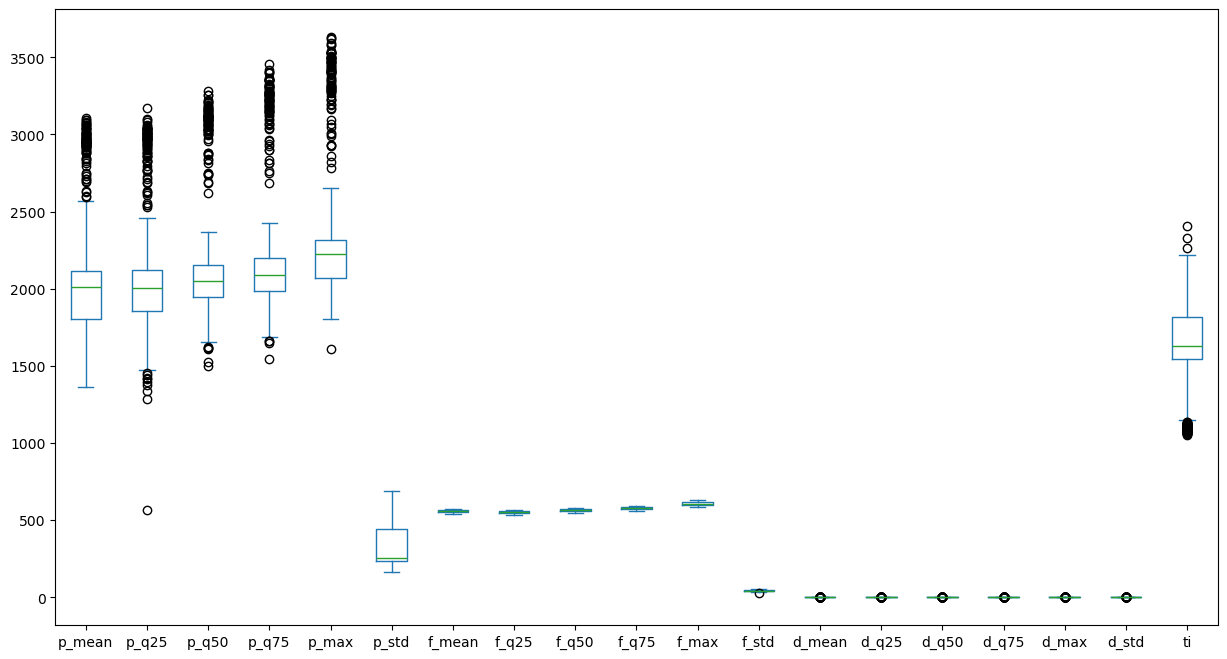

In [10]:
pd.DataFrame(X_train, columns=['p_mean', 'p_q25', 'p_q50', 'p_q75', 'p_max', 'p_std',
                               'f_mean', 'f_q25', 'f_q50', 'f_q75', 'f_max', 'f_std',
                               'd_mean', 'd_q25', 'd_q50', 'd_q75', 'd_max', 'd_std',
                                'ti']).plot(kind='box', figsize=(15,8))
plt.show()

Skalieren Trainingsdaten

In [11]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)

Skalieren Testdaten

In [12]:
X_test_scaled = std_scaler.transform(X_test)

PCA unskaliert (transformierte Features: Z)

In [13]:
pca_unscaled = decomposition.PCA(n_components=10)
# nur relevante Features (cor bzw. festigkeit ≥ 0.1)
#pca_unscaled = decomposition.PCA(n_components=5)
Z_train_unscaled = pca_unscaled.fit_transform(X_train)
Z_test_unscaled = pca_unscaled.transform(X_test)

<Axes: >

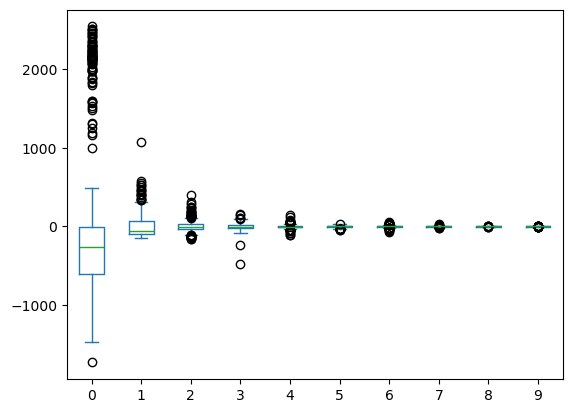

In [14]:
pd.DataFrame(Z_train_unscaled).plot(kind='box')

In [15]:
# erstmal DataFrame mit Features und Zielgröße aufbauen
df_train_unscaled = pd.DataFrame(Z_train_unscaled)
df_train_unscaled['festigkeit'] = festigkeit_train

In [16]:
corr_unscaled = df_train_unscaled.corr()
corr_unscaled['festigkeit'].abs().sort_values(ascending=False)

festigkeit    1.000000
0             0.816416
3             0.309599
1             0.279965
2             0.259542
4             0.136579
9             0.095706
8             0.040602
7             0.037394
5             0.026734
6             0.019599
Name: festigkeit, dtype: float64

Beobachtung: schnelles Abfallen der Korrelation zur Zielgröße, nur 5 Features relevant

Kontrollanzeige t-SNE

In [17]:
tsne_unscaled = manifold.TSNE(n_components=2)
Z_train_projected = tsne_unscaled.fit_transform(Z_train_unscaled)

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

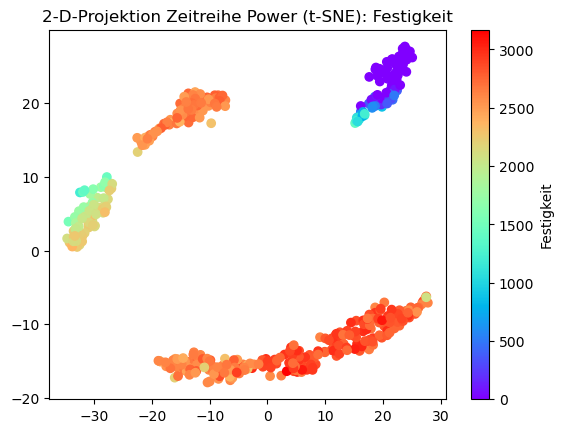

In [18]:
plt.scatter(Z_train_projected[:,0], Z_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

PCA (skaliert)

In [19]:
pca_scaled = decomposition.PCA(n_components=10)
# nur relevante Features (cor. bzgl. Festigkeit ≥ 0.1)
#pca_scaled = decomposition.PCA(n_components=8)
Z_train_scaled = pca_scaled.fit_transform(X_train_scaled)
Z_test_scaled = pca_scaled.transform(X_test_scaled)

<Axes: >

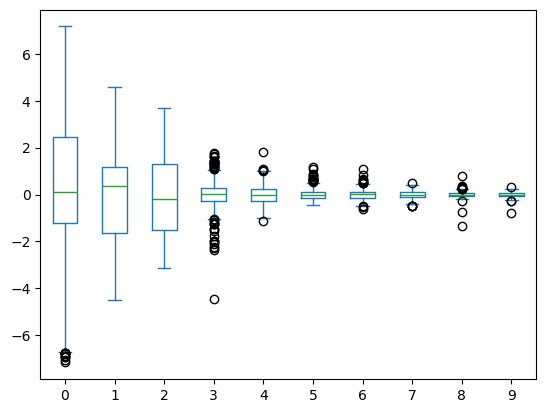

In [20]:
pd.DataFrame(Z_train_scaled).plot(kind='box')

In [21]:
# erstmal DataFrame mit Features und Zielgröße aufbauen
df_train_scaled = pd.DataFrame(Z_train_scaled)
df_train_scaled['festigkeit'] = festigkeit_train

In [22]:
corr = df_train_scaled.corr()
corr['festigkeit'].abs().sort_values(ascending=False)

festigkeit    1.000000
0             0.700859
2             0.387251
5             0.348510
4             0.221463
8             0.219317
1             0.181805
6             0.160829
3             0.147271
9             0.078052
7             0.002585
Name: festigkeit, dtype: float64

Beobachtung: langsameres Abfallen der Korrelation zur Zielgröße, 8 Features wahrscheinlich relevant

Kontrollanzeige t-SNE

In [23]:
tsne_scaled = manifold.TSNE(n_components=2)
Z_train_projected = tsne_scaled.fit_transform(Z_train_scaled)

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

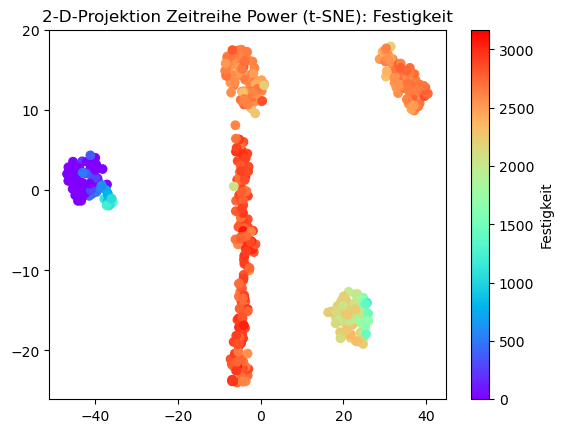

In [24]:
plt.scatter(Z_train_projected[:,0], Z_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

Beobachtung: An t-SNE-Plot kein Unterschied zwischen skalierten bzw. nichtskalierten Daten ablesbar

SVC (nur für PCA auf skalierten Daten)

In [25]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 4),      # 50 Werte zwischen 1 und 10000
    'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
}
estim_search = model_selection.RandomizedSearchCV(
    svm.SVC(),
    params,
    n_iter=50,
)
_ = estim_search.fit(Z_train_scaled, label_train)
estimator = estim_search.best_estimator_
print(estim_search.best_params_)

{'gamma': 0.7906043210907702, 'C': 16.768329368110074}


Accuracy

In [26]:
score_train = estimator.score(Z_train_scaled, label_train)
score_test = estimator.score(Z_test_scaled, label_test)
score_train, score_test

(1.0, 1.0)

Anzeige Confusion Matrix (Testdaten)

In [27]:
def plot_confusion(y_true, y_pred):
    conf = metrics.confusion_matrix(y_true, y_pred)
    metrics.ConfusionMatrixDisplay(conf).plot()

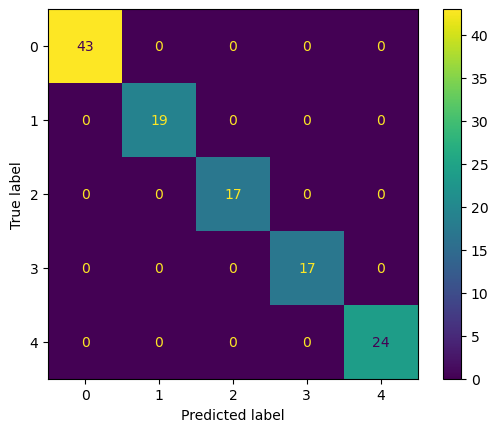

In [28]:
pred_test = estimator.predict(Z_test_scaled)
disp = plot_confusion(label_test, pred_test)
plt.savefig('svc_test_confusion.png')

SVM-Regressor (PCA auf unskalierten Daten)

In [29]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 5),      # 50 Werte zwischen 1 und 10000
    'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
    'epsilon': np.logspace(-2, 2) # 50 Werte zwischen 0.01 und 100
}
# alternativ RandomSearch
estim_unscaled = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=600, # ATTENTION: runs very long
    n_jobs=-1,
)
estim_unscaled.fit(Z_train_unscaled, festigkeit_train)
print('Best parameters:', estim_unscaled.best_params_)
best_estim_unscaled = estim_unscaled.best_estimator_

Best parameters: {'gamma': 1e-05, 'epsilon': 0.13894954943731375, 'C': 4714.866363457394}


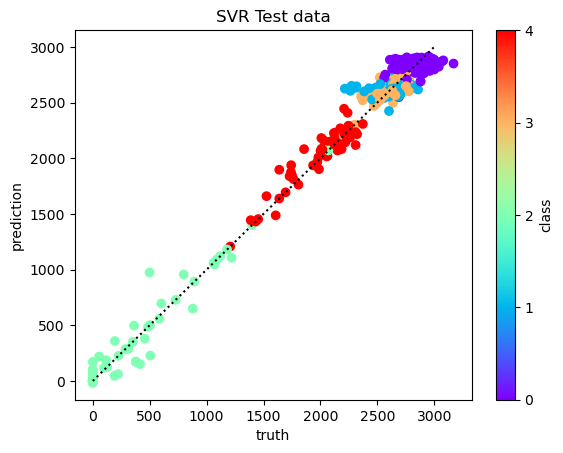

In [30]:
y_pred_train = best_estim_unscaled.predict(Z_train_unscaled)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_train.png')

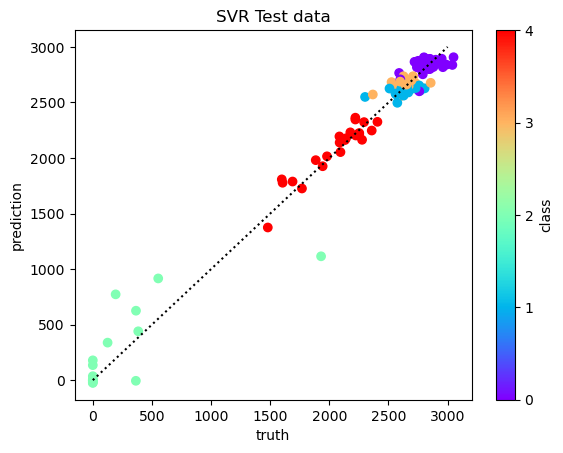

In [31]:
y_pred_test = best_estim_unscaled.predict(Z_test_unscaled)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_test.png')

In [32]:
y_pred_train = best_estim_unscaled.predict(Z_train_unscaled)
y_pred_test = best_estim_unscaled.predict(Z_test_unscaled)
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")
# mapi ist nutzlos durch 0-Werte bei Zugfestigkeit
#mapi_train = metrics.mean_absolute_percentage_error(festigkeit_train, y_pred_train)
#mapi_test = metrics.mean_absolute_percentage_error(festigkeit_test, y_pred_test)
#print(f"MAPI: train {mapi_train:8.1f}, test: {mapi_test:8.1f}")

MSE: train  10057.1, test:  19332.2
RMSE: train    100.3 test:    139.0
MAE: train     67.6, test:     89.2


SVR auf PCA-Daten (skalierte Features)

In [33]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 5),      # 50 Werte zwischen 1 und 10000
    'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
    'epsilon': np.logspace(-2, 2) # 50 Werte zwischen 0.01 und 100
}
# alternativ RandomSearch
estim_scaled = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=600, # ATTENTION: runs very long
    n_jobs=-1,
)
estim_scaled.fit(Z_train_scaled, festigkeit_train)
print('Best parameters:', estim_scaled.best_params_)
best_estim_scaled = estim_scaled.best_estimator_

Best parameters: {'gamma': 0.0625055192527397, 'epsilon': 47.1486636345739, 'C': 4714.866363457394}


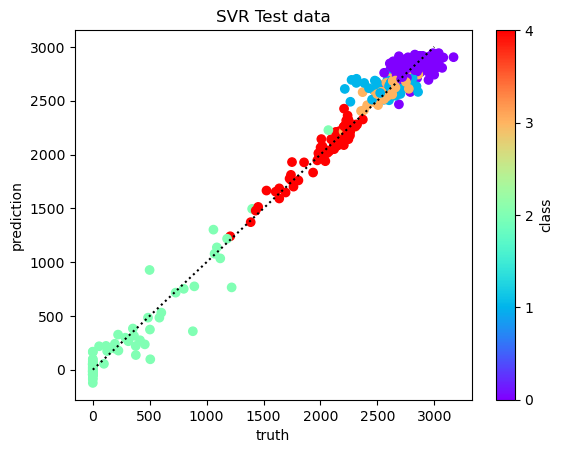

In [34]:
y_pred_train = best_estim_scaled.predict(Z_train_scaled)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_train.png')

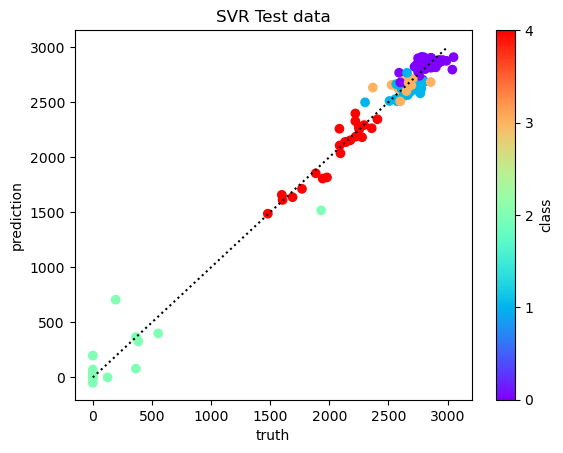

In [35]:
y_pred_test = best_estim_scaled.predict(Z_test_scaled)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_test.png')

In [36]:
y_pred_train = best_estim_scaled.predict(Z_train_scaled)
y_pred_test = best_estim_scaled.predict(Z_test_scaled)
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")
# mapi ist nutzlos durch 0-Werte bei Zugfestigkeit
#mapi_train = metrics.mean_absolute_percentage_error(festigkeit_train, y_pred_train)
#mapi_test = metrics.mean_absolute_percentage_error(festigkeit_test, y_pred_test)
#print(f"MAPI: train {mapi_train:8.1f}, test: {mapi_test:8.1f}")

MSE: train  10464.1, test:  11596.9
RMSE: train    102.3 test:    107.7
MAE: train     74.0, test:     73.9
